In [126]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.model_selection import train_test_split
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from sklearn.ensemble import RandomForestClassifier


In [127]:
data_path = './data'
no_clusters = 100
splitProp = 0.8

In [128]:
def loadDataset(): #Function to parse through the directory and append the required images and their labels
    imgs = []
    labels = []
    label = -1
    
    directories = [f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))]
    
    for directory in directories:
        label = label + 1
        path = data_path+'/'+directory
        files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
        
        for file in files:
            imgPath = path+'/'+file
            imgs.append(imgPath)
            labels.append(label)
    
    return (imgs,labels)


In [129]:
dataset = loadDataset()

In [130]:
trainImgPaths,testImgPaths, trainLabels, testLabels = train_test_split(dataset[0], dataset[1], 
                                                train_size=splitProp, random_state=42,shuffle = True,stratify = dataset[1])

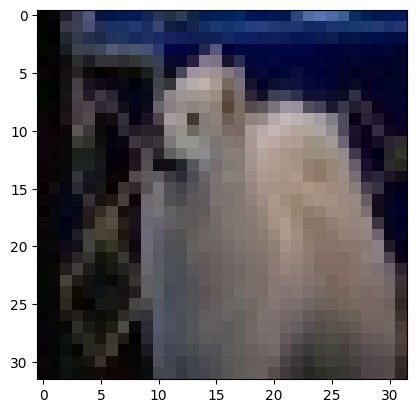

In [131]:
testImage = plt.imread(trainImgPaths[0])
plt.imshow(testImage)

In [132]:
def getImages(imgsPath):
    imgs = []
    for imgName in imgsPath:
        img = cv2.imread(imgName)
        imgs.append(img)
    imgs = np.asarray(imgs,dtype=object)
    return imgs

In [133]:
trainImgs = getImages(trainImgPaths)

In [134]:

def getDescriptors(sift, img): #Function to detect the key points and their descriptors
    kp, des = sift.detectAndCompute(img, None)
    return des



In [135]:
def extract(imgs): #Extracting all the descriptors of images
    desc_list = []
    count = 0
    index = 0
    index_list = []
    sift = cv2.SIFT_create()
    for img in imgs:
        desc = getDescriptors(sift,img)
        if(desc is not None):
            count = count+1
            desc_list.append(desc)
        else:
            index_list.append(index)
        index = index+1


    return desc_list,count,index_list


In [136]:
def deleteIndex(trainImgs,trainLabels,index_list): #Deleting those labels and points which dont have descriptors
    trainLabels=np.delete(trainLabels,index_list)
    trainImgs=np.delete(trainImgs, index_list)
    return trainImgs, trainLabels

In [137]:
def vstackDescriptors(descriptor_list): #Reorganizing the descriptor list
    descriptors = np.array(descriptor_list[0])
    for descriptor in descriptor_list[1:]:
        descriptors = np.vstack((descriptors, descriptor)) 

    return descriptors



In [138]:
def clusterDescriptors(descriptors, no_clusters): #Applying kmeans on the descriptors
    kmeans = KMeans(n_clusters = no_clusters).fit(descriptors)
    return kmeans



In [139]:
def extractFeatures(kmeans, descriptor_list, image_count, no_clusters): #Creating histograms which will later be used by the ML model as features
    im_features = np.array([np.zeros(no_clusters) for i in range(image_count)])
    for i in range(image_count):
        for j in range(len(descriptor_list[i])):
            feature = descriptor_list[i][j]
            feature = feature.reshape(1, 128)
            idx = kmeans.predict(feature)
            im_features[i][idx] += 1

    return im_features



In [140]:
def normalizeFeatures(scale, features): #Normalizing the features
    return scale.transform(features)

In [141]:
dataset = loadDataset()
trainImgPaths,testImgPaths, trainLabels, testLabels = train_test_split(dataset[0], dataset[1], 
                                                train_size=0.8, random_state=42,shuffle = True,stratify = dataset[1])

In [142]:
trainImgs = getImages(trainImgPaths)


In [143]:
trainImgs = np.array(trainImgs).astype('uint8')
# 

In [144]:
desc_list,train_count,train_index_list=extract(trainImgs)


In [145]:
trainImgs,trainLabels = deleteIndex(trainImgs, trainLabels,train_index_list)

In [146]:
descriptors = vstackDescriptors(desc_list)

In [147]:
kmeans = clusterDescriptors(descriptors, no_clusters=no_clusters)


In [148]:
im_features= extractFeatures(kmeans, desc_list, train_count, no_clusters=no_clusters)


In [149]:
scale = StandardScaler().fit(im_features)    
im_features = scale.transform(im_features)

In [150]:
LRG = linear_model.LogisticRegression().fit(im_features, trainLabels)


In [153]:
def test(testImgPaths,kmeans,LRG,scale,testLabels):
    testImgs = getImages(testImgPaths)
    testImgs = np.array(testImgs).astype('uint8')
    desc_list,count,index_list=extract(testImgs)
    test_imgs,testLabels = deleteIndex(testImgs, testLabels,index_list)
    descriptors = vstackDescriptors(desc_list)
    test_features = extractFeatures(kmeans, desc_list, count, no_clusters=no_clusters)
    test_features = scale.transform(test_features)
    pred=LRG.predict(test_features)
    return pred,testLabels,index_list,test_features

In [154]:
pred,testLabels,test_index_list,test_features = test(testImgPaths,kmeans,LRG,scale,testLabels)

In [155]:
accuracy_score(pred, testLabels)

0.639344262295082

In [173]:
learner = ActiveLearner(estimator=RandomForestClassifier(),query_strategy=uncertainty_sampling,X_training=im_features, y_training=trainLabels)

In [181]:
initial_sample_idx = np.random.choice(range(len(im_features)), size=int(0.2*len(im_features)), replace=False)
learner.teach(im_features[initial_sample_idx], trainLabels[initial_sample_idx])
scores = []
# Iterate through active learning cycles until a stopping criterion is met
for i in range(50):
    # print(i)
    # Query the most informative samples from the unlabeled set
    query_idx, query_inst = learner.query(im_features, n_instances=10)
    
    # Label the queried samples and add them to the training set
    y_new = [np.random.randint(2) for _ in range(10)]
    learner.teach(im_features[query_idx], y_new)
    
    # Evaluate the model on the test set
    score = learner.score(test_features, testLabels)
    # print(f"Test set score after {i+1} active learning cycles: {score}")
    scores.append(score)

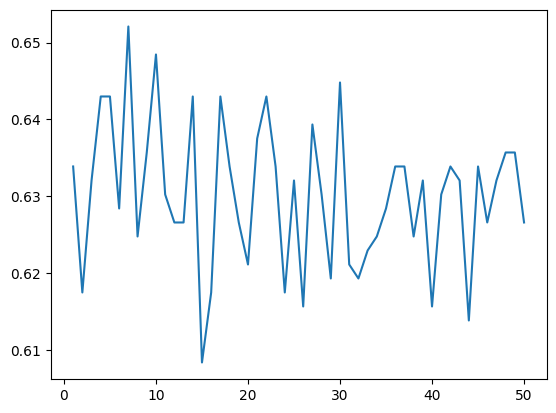

In [182]:
ks=(np.arange(1, 51, 1))
ks
plt.plot(ks, scores)


In [183]:
scores[-1]

0.6265938069216758